In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("Economic_data.csv")
relevant_columns = ['Year', 'Country', 'Inflation_Rate', 'GDP_Per_Capita', 'GDP_Growth_Rate', 
                    'Unemployment_Rate', 'Cost of Living Index','Local Purchasing Power Index']

df = df[relevant_columns]

# Fill missing values with country-specific mean
def fill_na_with_country_mean(df, column):
    return df[column].fillna(df.groupby('Country')[column].transform('mean'))

# Fill initial columns with country mean
df['Inflation_Rate'] = fill_na_with_country_mean(df, 'Inflation_Rate')
df['GDP_Per_Capita'] = fill_na_with_country_mean(df, 'GDP_Per_Capita')
df['GDP_Growth_Rate'] = fill_na_with_country_mean(df, 'GDP_Growth_Rate')

In [3]:
features = ['Inflation_Rate', 'GDP_Per_Capita', 'GDP_Growth_Rate', 'Unemployment_Rate']
targets = ['Cost of Living Index', 'Local Purchasing Power Index','Unemployment_Rate']

# Combine features and targets for imputation
all_columns = features + targets

# Split data for training and testing
train_data = df[df['Year'] >= 2012].dropna(subset=all_columns)
test_data = df[df['Year'] < 2012]

param_distributions = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [1, 0.5, 0.3]
}

In [4]:
best_params_dict = {}
for target in targets:
    # Define features and target for training
    X_train = train_data[features]
    y_train = train_data[target]
    
    # Initialize RandomForestRegressor with hyperparameter tuning
    rf = RandomForestRegressor(random_state=42)
    random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_distributions,
        n_iter=30,  # Set to 10 for a balance between speed and accuracy
        scoring='neg_mean_squared_error',
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=-1,
        error_score='raise'  # Set error_score to 'raise' to catch failed fits
    )
    
    # Fit the model
    try:
        random_search.fit(X_train, y_train)
        best_params_dict[target] = random_search.best_params_
        best_rf = random_search.best_estimator_

        # Print best parameters for each target
        print(f"Best parameters for {target}: {random_search.best_params_}")

        # Predict missing values in the test set
        X_test = test_data[features]
        test_data.loc[:, target] = best_rf.predict(X_test)
        
    except Exception as e:
        print(f"An error occurred while fitting the model for {target}: {e}")


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters for Cost of Living Index: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.5, 'max_depth': 30}
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters for Local Purchasing Power Index: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.5, 'max_depth': None}
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters for Unemployment_Rate: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 10}


In [20]:
combined_data = pd.concat([test_data, train_data])
combined_data.to_csv('imputed_data_Economic.csv', index=False)

#### Testing the Imputation Model

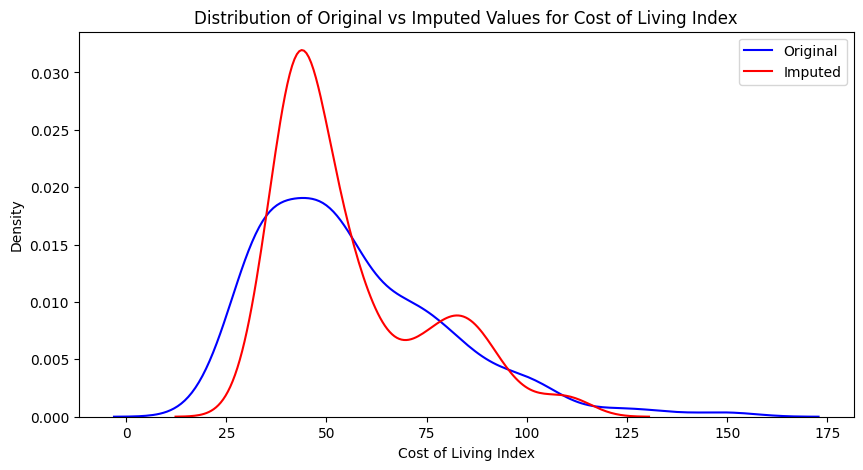

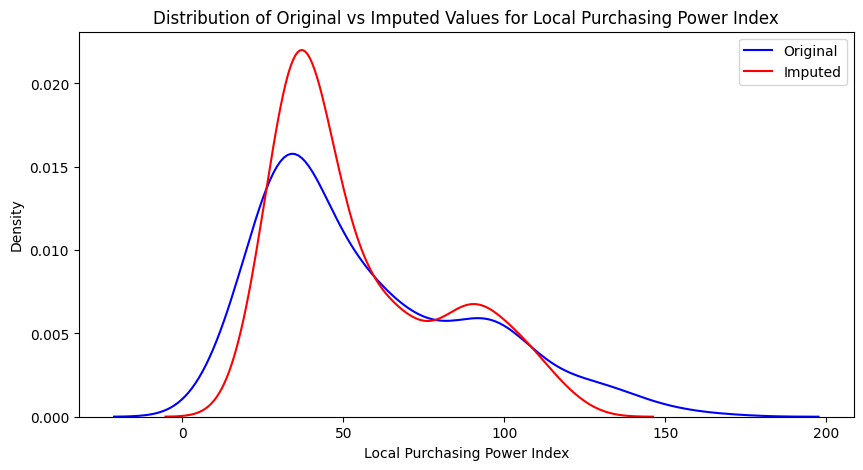

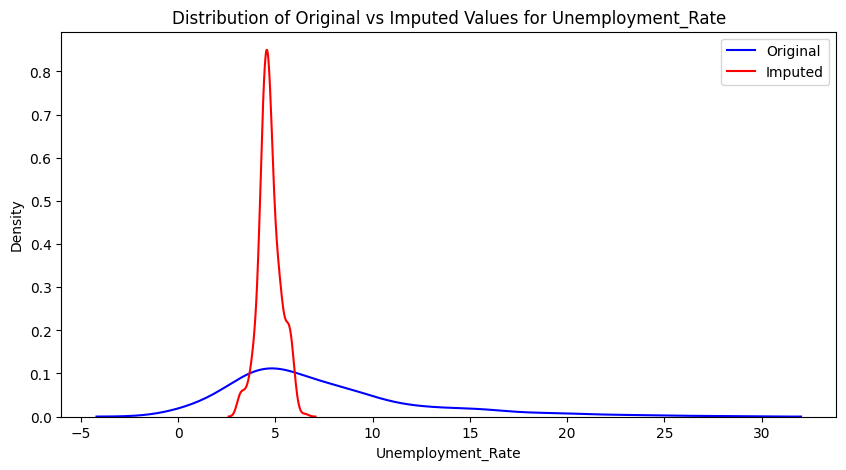

                         target       R^2       RMSE        MAE
0          Cost of Living Index  0.719241  12.408672   9.604446
1  Local Purchasing Power Index  0.691469  18.353394  11.713820
2             Unemployment_Rate -0.247636   5.392031   3.594736


In [23]:
synthetic_data = train_data.copy()
synthetic_data = synthetic_data.dropna()

for target in targets:
    mask = synthetic_data[target].notna()
    n_to_remove = int(0.35 * mask.sum())
    indices_to_nan = np.random.choice(synthetic_data[mask].index, n_to_remove, replace=False)
    synthetic_data.loc[indices_to_nan, target] = np.nan

# Dictionary to store evaluation metrics
metrics = {'target': [], 'R^2': [], 'RMSE': [], 'MAE': []}

# Impute each target column and calculate metrics
for target in targets:
    train_synthetic = synthetic_data[synthetic_data[target].notna()]
    test_synthetic = synthetic_data[synthetic_data[target].isna()]
    
    X_train = train_synthetic[features]
    y_train = train_synthetic[target]
    X_test = test_synthetic[features]
    y_true = train_data.loc[test_synthetic.index, target]
    
    # Retrieve best parameters for this target
    best_params = best_params_dict[target]
    
    # Set up RandomForestRegressor with best parameters
    rf = RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        max_features=best_params['max_features'],
        random_state=42
    )
    
    # Fit and predict
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # Calculate evaluation metrics
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # Append metrics for this target
    metrics['target'].append(target)
    metrics['R^2'].append(r2)
    metrics['RMSE'].append(rmse)
    metrics['MAE'].append(mae)
    
    # Plot distribution comparison
    plt.figure(figsize=(10, 5))
    sns.kdeplot(y_true, label='Original', color='blue')
    sns.kdeplot(y_pred, label='Imputed', color='red')
    plt.title(f"Distribution of Original vs Imputed Values for {target}")
    plt.xlabel(target)
    plt.legend()
    plt.show()

# Display metrics as a DataFrame
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

In [6]:
best_params = {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.5, 'max_depth': 30}

In [10]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load the full dataset
full_data = pd.read_csv('synthetic_data_full.csv')

# Split the full data into 60-40 for training and testing
train_data, test_data = train_test_split(full_data, test_size=0.4, random_state=29)

# Create synthetic missing data in the test set by randomly setting values to NaN
np.random.seed(29)
missing_fraction = 0.3  # 70% of the data will be randomly masked as NaN
for column in test_data.columns:
    mask = np.random.rand(test_data.shape[0]) < missing_fraction
    test_data.loc[mask, column] = np.nan

# Initialize metrics storage
metrics = {'target': [], 'R^2': [], 'RMSE': [], 'MAE': []}

# Perform imputation and evaluation over 30 runs
for run in range(30):
    # Initialize Iterative Imputer with RandomForestRegressor using best parameters
    rf_imputer = IterativeImputer(
        estimator=RandomForestRegressor(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            min_samples_split=best_params['min_samples_split'],
            min_samples_leaf=best_params['min_samples_leaf'],
            max_features=best_params['max_features'],
            random_state=29 + run
        ),
        random_state=29 + run
    )

    # Perform imputation on the test data
    test_data_imputed = pd.DataFrame(rf_imputer.fit_transform(test_data), columns=test_data.columns)

    # Calculate metrics for each column with synthetic missing values
    missing_columns = test_data.columns[test_data.isnull().any()]

    for column in missing_columns:
        y_true = full_data.loc[test_data.index, column]  # Use the original full data as ground truth
        y_pred = test_data_imputed[column]

        # Calculate metrics
        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)

        # Append metrics for this target
        metrics['target'].append(column)
        metrics['R^2'].append(r2)
        metrics['RMSE'].append(rmse)
        metrics['MAE'].append(mae)

# Display metrics as a DataFrame
metrics_df = pd.DataFrame(metrics)
print(metrics_df)


C:\Users\Tanay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\Tanay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\Tanay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\Tanay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [Itera

             target       R^2          RMSE          MAE
0   GDP_Growth_Rate  0.680803      3.735422     1.331692
1    GDP_Per_Capita  0.664582   9759.058821  3400.999105
2   GDP_Growth_Rate  0.659588      3.857563     1.419017
3    GDP_Per_Capita  0.650373   9963.633542  3640.217699
4   GDP_Growth_Rate  0.659703      3.856911     1.392788
5    GDP_Per_Capita  0.658261   9850.593376  3156.903101
6   GDP_Growth_Rate  0.667849      3.810464     1.345690
7    GDP_Per_Capita  0.651340   9949.832241  3073.487131
8   GDP_Growth_Rate  0.649405      3.914831     1.441250
9    GDP_Per_Capita  0.631800  10224.844498  3432.826758
10  GDP_Growth_Rate  0.665806      3.822166     1.387813
11   GDP_Per_Capita  0.648372   9992.100853  3651.870328
12  GDP_Growth_Rate  0.668300      3.807877     1.355475
13   GDP_Per_Capita  0.654110   9910.234350  3557.877832
14  GDP_Growth_Rate  0.669573      3.800562     1.331040
15   GDP_Per_Capita  0.667398   9718.012952  3182.698190
16  GDP_Growth_Rate  0.676488  

C:\Users\Tanay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [11]:
metrics_summary = metrics_df.groupby('target').agg(
    R2_mean=('R^2', 'mean'),
    R2_std=('R^2', 'std'),
    RMSE_mean=('RMSE', 'mean'),
    RMSE_std=('RMSE', 'std'),
    MAE_mean=('MAE', 'mean'),
    MAE_std=('MAE', 'std')
).reset_index()

print(metrics_summary)

            target   R2_mean    R2_std     RMSE_mean    RMSE_std     MAE_mean  \
0  GDP_Growth_Rate  0.663326  0.046484      3.829567    0.231516     1.368868   
1   GDP_Per_Capita  0.647392  0.017842  10003.011521  249.459769  3390.688322   

      MAE_std  
0    0.127610  
1  305.831754  
